# Analysis of excitonic states

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


We read the coupling matrix and dipoles (with the highest given number of virtual orbitals)

In [2]:
nVirtMax = 303
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_'+str(nVirtMax)+'.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_'+str(nVirtMax)+'.txt'
Cmat = np.loadtxt(cpath)
%cd ..
Cmat.shape

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


(3030, 3030)

We set the number of empty and virtual states and build the C submatrix with the chosen values of nalpha

In [3]:
numOrb = 5
nalpha = [32,64,128,nVirtMax]

We compute the eigenvalues and vectors of C_ext (linalg.eigh gives the eigenvectors in the transpose form so we peform an explicit transpose to the vectors sorted as row vectors)

In [4]:
eigenproblems = {}
for na in nalpha:
    C_ext,dipoles_ext=R.extract_subset([numOrb],[nVirtMax],Cmat,dipoles,[na])
    print C_ext.shape
    E2,C_E2 = np.linalg.eigh(C_ext)
    C_E2 = C_E2.T
    eigenproblems[na] = (C_ext,E2,C_E2)

(320, 320)
(640, 640)
(1280, 1280)
(3030, 3030)


In [5]:
for na in nalpha:
    C_ext = eigenproblems[na][0]
    E2 = eigenproblems[na][1]
    C_E2 = eigenproblems[na][2]
    for ind,e in enumerate(E2):
        isok = np.allclose(C_ext.dot(C_E2[ind]),e*C_E2[ind],atol=1.e-12)
        if not isok: print('Eigenvalue',ind,'is false')
print('Validation terminated')

Validation terminated


We compute the contribution of the virtual states in the lower energy eigenstates of C_ext

In [14]:
reload(R)
exc = [0,1,2,3,7,8] # [i for i in range(20)] # select the list of excitation index
inda = len(nalpha)-1 # select the number of virtual states
print 'nalpha = ', nalpha[inda]
print ''
weightP,weightAlpha = R.weight(numOrb,nalpha[inda],exc,eigenproblems[nalpha[inda]][2],eigenproblems[nalpha[inda]][1])

for w in weightAlpha:
    s = 0.0
    for i in w:
        s+=i
    if np.allclose(s,1.0,atol=1.e-12) == False:
        print 'norm error on virtual states'
for w in weightP:
    s = 0.0
    for i in w:
        s+=i
    if np.allclose(s,1.0,atol=1.e-12) == False:
        print 'norm error on occupied states'

nalpha =  303

Exctation number : 1  energy =  0.268571229762
  ******* occupied state contribution ********
  occupied state : 3  weight =  0.498515591291
  occupied state : 4  weight =  0.498518966476
  1 - sumOverThreshold p =  2.965e-03
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.495473966778
  virtual state  : 2  weight =  0.495485240895
  1 - sumOverThreshold alpha =  9.041e-03

Exctation number : 2  energy =  0.269882874652
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.999450975096
  1 - sumOverThreshold p =  5.490e-04
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.997945825866
  1 - sumOverThreshold alpha =  2.054e-03

Exctation number : 3  energy =  0.26988299778
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.999443205895
  1 - sumOverThreshold p =  5.568e-04
  ******* virtual state contribution *********
  virtual state  : 2  weight =  0.

We analyze the formation of wave packet in the virtual states with a low weight on the eigenvectors of C. We consider a single excitation and plot the contribution of the states below the threshold (for each value of the number of virtual states)

nalpha =  32
Exctation number : 1  energy =  0.270744160786
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.99974275101
  1 - sumOverThreshold p =  2.572e-04
  ******* virtual state contribution *********
  virtual state  : 2  weight =  0.999495503353
  1 - sumOverThreshold alpha =  5.045e-04

nalpha =  64
Exctation number : 1  energy =  0.270583515891
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.99965926888
  1 - sumOverThreshold p =  3.407e-04
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.999353603709
  1 - sumOverThreshold alpha =  6.464e-04

nalpha =  128
Exctation number : 1  energy =  0.269959679516
  ******* occupied state contribution ********
  occupied state : 3  weight =  0.498665597369
  occupied state : 4  weight =  0.498663588088
  1 - sumOverThreshold p =  2.671e-03
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.49579786782
  virtual s

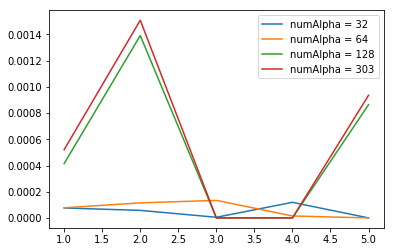

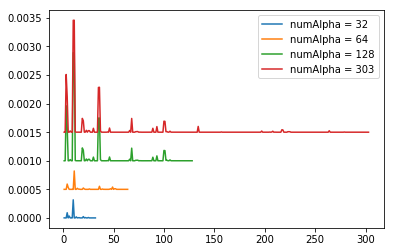

In [16]:
exc = [0] #select the excitation index
weightP = []
weightAlpha = []
for inda in range(len(nalpha)):
    print 'nalpha = ', nalpha[inda]
    wP,wAlpha = R.weight(numOrb,nalpha[inda],exc,eigenproblems[nalpha[inda]][2],eigenproblems[nalpha[inda]][1])
    weightP.append(wP[0])
    weightAlpha.append(wAlpha[0])
    
# remove the component above th treshold
weightAlphaCut = weightAlpha
for a in range(len(nalpha)):
    for i,w in enumerate(weightAlphaCut[a]):
        if w > 0.1:
            weightAlphaCut[a][i] = 0.0
weightPCut = weightP
for a in range(len(nalpha)):
    for i,w in enumerate(weightPCut[a]):
        if w > 0.1:
            weightPCut[a][i] = 0.0
#plot
p = [i for i in range(1,numOrb+1)]
for a in range(len(nalpha)):
    plt.plot(p,weightPCut[a],label = 'numAlpha = ' + str(nalpha[a]))
    plt.legend()
plt.show()

offs = 0
for a in range(len(nalpha)):
    alpha = [i for i in range(1,nalpha[a]+1)]
    plt.plot(alpha,offs + weightAlphaCut[a],label = 'numAlpha = ' + str(nalpha[a]))
    offs+=5e-4 #2e-13 
    plt.legend()
plt.show()